In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/custom

/content/drive/MyDrive/custom


In [3]:
data_path = '/content/drive/MyDrive/custom/nepaliintents.json'


In [5]:
import json
import time
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import nltk

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [6]:
def read_data(file_path):
  pairs = []
  with open(data_path, 'r') as f:
    data = json.load(f)

  return data

In [7]:
data = read_data(data_path)


In [8]:
training_sentences = []
training_labels = []
labels = []
responses = []
val_sentences = []
val_labels = []

for intent in data['intents']:
    num_patterns = len(intent['patterns'])
    num_train = int(0.8 * num_patterns)  # Adjust the split ratio as needed

    for i, pattern in enumerate(intent['patterns']):
        if i >= num_train:
            val_sentences.append(pattern)
            val_labels.append(intent['tag'])
        else:
            training_sentences.append(pattern)
            training_labels.append(intent['tag'])

    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

NUM_CLASSES = len(labels)
print(NUM_CLASSES)


69


In [9]:
print(len(val_labels))

145


In [10]:
print(len(training_labels))

548


In [11]:
print(labels)

['greeting', 'goodbye', 'location', 'aboutme', 'registration', 'faculty', 'extracurriculumactivities', 'collegetime', 'clubs', 'programs', 'error', 'computerengineeringseats', 'civilengineeringseats', 'architectureseats', 'electronicsengineeringseats', 'contactnumber', 'admissiondocuments', 'other', 'diploma', 'computerhod', 'electricalhod', 'civilhod', 'electronicshod', 'architecturehod', 'principal', 'chairman', 'viceprincipal', 'civilfacultymembers', 'electricalfacultymembers', 'electronicsfacultymembers', 'architecturefacultymembers', 'feestructure', 'scholarshipscheme', 'accomodationfacilities', 'collegedays', 'studentnumber', 'teachernumber', 'establish', 'creator', 'building', 'library', 'resources', 'computerfacultymembers', 'attendance', 'disqualification', 'idcard', 'uniform', 'clubsintro', 'electricalclub', 'roboticsclub', 'epclub', 'akarclub', 'itclub', 'cesaclub', 'yogaclub', 'boyshostel', 'girlshostel', 'projectinfo', 'computerprojects', 'electronicsprojects', 'electrical

In [12]:
train_pairs = []
val_pairs = []
for i in range(len(training_sentences)):
  train_pairs.append((training_sentences[i], training_labels[i]))

for i in range(len(val_sentences)):
  val_pairs.append((val_sentences[i], val_labels[i]))

random.shuffle(train_pairs)
random.shuffle(val_pairs)

In [13]:
print(train_pairs)
print(len(train_pairs))

[('केईसीका उपप्रमुख को हुन् ?', 'viceprincipal'), ('faculty', 'faculty'), ('के म तपाईको कलेजको शुल्क संरचना बारे जानकारी पाउन सक्छु?', 'feestructure'), ('college ko vice principal ko ho', 'viceprincipal'), ('kec को प्रमुख को हो?', 'principal'), ('electronics engineering ma kati ota seat huncha?', 'electronicsengineeringseats'), ('कुन कुन क्लबहरू छन्?', 'clubs'), ('malai bct ko 8th sem ko dincharya pradan garnuhos', 'bct8thsemroutine'), ('architecture faculty ko hod ko ho', 'architecturehod'), ('boys hostel कसरी दर्ता गर्ने?', 'boyshostel'), ('BArch पाठ्यक्रम', 'architecturecurriculum'), ('सिविलको संकाय सदस्य कोको हुन् ?', 'civilfacultymembers'), ('college ko time k ho?', 'collegetime'), ('iv/ii board exam routine', 'examroutine'), ('project pani exam ho', 'projectinfo'), ('इलेक्ट्रोनिक्स परियोजना क्लब के हो', 'epclub'), ('काठमाडौं इन्जिनियरिङ कलेजमा कस्ता क्लबहरू छन्?', 'clubsintro'), ('इलेक्ट्रोनिक्स विभागमा कतिवटा प्रोजेक्ट बुझाउनुपर्छ', 'electronicsprojects'), ('के.इ.सी.मा दर्ता गर्

In [14]:
print(val_pairs)
print(len(val_pairs))

[('कलेजमा शिक्षकहरूको संख्या कति छ?', 'teachernumber'), ('किन id card chahiyo', 'idcard'), ('it club vaneko k ho', 'itclub'), ('yoga संघको महत्व', 'yogaclub'), ('electronic hod', 'electronicshod'), ('सिविल संकायका शिक्षकहरूको सूची', 'civilfacultymembers'), ('प्रोजेक्ट वारीमा कति डिफेन्स लिन्छ?', 'defenseproject'), ('इलेक्ट्रोनिक्स परियोजना क्लब के हो?', 'epclub'), ('वाईफाई', 'resources'), ('सॉफ्टवेयर', 'resources'), ('सिभिल इन्जिनियरिङ् को हेड अफ डिपार्टमेन्ट को हो?', 'electronicshod'), ('कलेज हप्तामा कति दिन हुन्छ?', 'collegedays'), ('कलेज को स्थान?', 'location'), ('kati jana huncha computer engineering ma?', 'civilengineeringseats'), ('के girls hostel को अवस्था राम्रो छ?', 'girlshostel'), ('कलेज को स्थापना को मिति के हो?', 'establish'), ('मलाई कम्प्युटर संकायको 8th sem ko adt दिनचर्या प्रदान गर्नुहोस्', 'adtroutine'), ('computer engineering ma kati ota seat huncha?', 'architectureseats'), ('अयोग्यता मापदण्ड', 'disqualification'), ('kec kata cha', 'location'), ('होस्टेलको कित्ता साइजक

In [15]:
for pair in train_pairs:
    print(pair)

('केईसीका उपप्रमुख को हुन् ?', 'viceprincipal')
('faculty', 'faculty')
('के म तपाईको कलेजको शुल्क संरचना बारे जानकारी पाउन सक्छु?', 'feestructure')
('college ko vice principal ko ho', 'viceprincipal')
('kec को प्रमुख को हो?', 'principal')
('electronics engineering ma kati ota seat huncha?', 'electronicsengineeringseats')
('कुन कुन क्लबहरू छन्?', 'clubs')
('malai bct ko 8th sem ko dincharya pradan garnuhos', 'bct8thsemroutine')
('architecture faculty ko hod ko ho', 'architecturehod')
('boys hostel कसरी दर्ता गर्ने?', 'boyshostel')
('BArch पाठ्यक्रम', 'architecturecurriculum')
('सिविलको संकाय सदस्य कोको हुन् ?', 'civilfacultymembers')
('college ko time k ho?', 'collegetime')
('iv/ii board exam routine', 'examroutine')
('project pani exam ho', 'projectinfo')
('इलेक्ट्रोनिक्स परियोजना क्लब के हो', 'epclub')
('काठमाडौं इन्जिनियरिङ कलेजमा कस्ता क्लबहरू छन्?', 'clubsintro')
('इलेक्ट्रोनिक्स विभागमा कतिवटा प्रोजेक्ट बुझाउनुपर्छ', 'electronicsprojects')
('के.इ.सी.मा दर्ता गर्ने प्रक्रिया', 'reg

In [16]:
t_queries = [pair[0] for pair in train_pairs]
t_labels = [pair[1] for pair in train_pairs]

v_queries = [pair[0] for pair in val_pairs]
v_labels = [pair[1] for pair in val_pairs]

In [17]:
len(t_queries), len(t_labels)


(548, 548)

In [18]:
len(v_queries), len(v_labels)


(145, 145)

In [19]:
le = LabelEncoder()
le.fit(training_labels)
y = le.transform(t_labels)
val_y = le.transform(v_labels)

In [20]:
vocab_size = 1000
embedding_dim = 32
max_len = 10
oov_token = '<OOV>'

In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(t_queries)
word_index = tokenizer.word_index
t_sequences = tokenizer.texts_to_sequences(t_queries)
t_padded_sequences = pad_sequences(t_sequences, truncating='post', maxlen=max_len)

v_sequences = tokenizer.texts_to_sequences(v_queries)
V_padded_sequences = pad_sequences(v_sequences, truncating='post', maxlen=max_len)

In [22]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(0.01),
                          activity_regularizer=tf.keras.regularizers.L2(0.01)), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [23]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [97]:
# Transformer block
embed_dim = 64
num_heads = 4
ff_dim = 32

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.4)(x)

# Add a dense layer
x = layers.Dense(64, activation="relu")(x)

# Add BatchNormalization
x = layers.BatchNormalization()(x)

# Additional Dense Layer
# x = layers.Dense(32, activation="relu")(x)

# Continue with more layers as needed
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [98]:
model.summary()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 10)]              0         
                                                                 
 token_and_position_embeddi  (None, 10, 64)            64640     
 ng_15 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_15 (Tran  (None, 10, 64)            70816     
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_65 (Dropout)        (None, 64)                0  

In [99]:
patience = 2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    t_padded_sequences,
    np.array(y),
    validation_data=(V_padded_sequences, np.array(val_y)),
    batch_size=32, epochs=100, callbacks=[early_stopping]
)

Epoch 1/100
18/18 [==============================] - 4s 39ms/step - loss: 7.5347 - accuracy: 0.0109 - val_loss: 6.8581 - val_accuracy: 0.0138
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 6.9682 - accuracy: 0.0164 - val_loss: 6.6766 - val_accuracy: 0.0138
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 6.6319 - accuracy: 0.0292 - val_loss: 6.3744 - val_accuracy: 0.0138
Epoch 4/100
18/18 [==============================] - 0s 18ms/step - loss: 6.4408 - accuracy: 0.0128 - val_loss: 6.0952 - val_accuracy: 0.0138
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 6.1927 - accuracy: 0.0347 - val_loss: 5.8259 - val_accuracy: 0.0483
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 5.7700 - accuracy: 0.0456 - val_loss: 5.5753 - val_accuracy: 0.0276
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 5.5160 - accuracy: 0.0438 - val_loss: 5.2972 - val_accuracy: 0.0483
Epoch 

In [28]:
def plot_graphs(history, metric):
    plt.plot(history.history.history[metric])
    plt.plot(history.history.history['val_'+ metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [29]:
plt.rcParams.update({'font.size': 22})


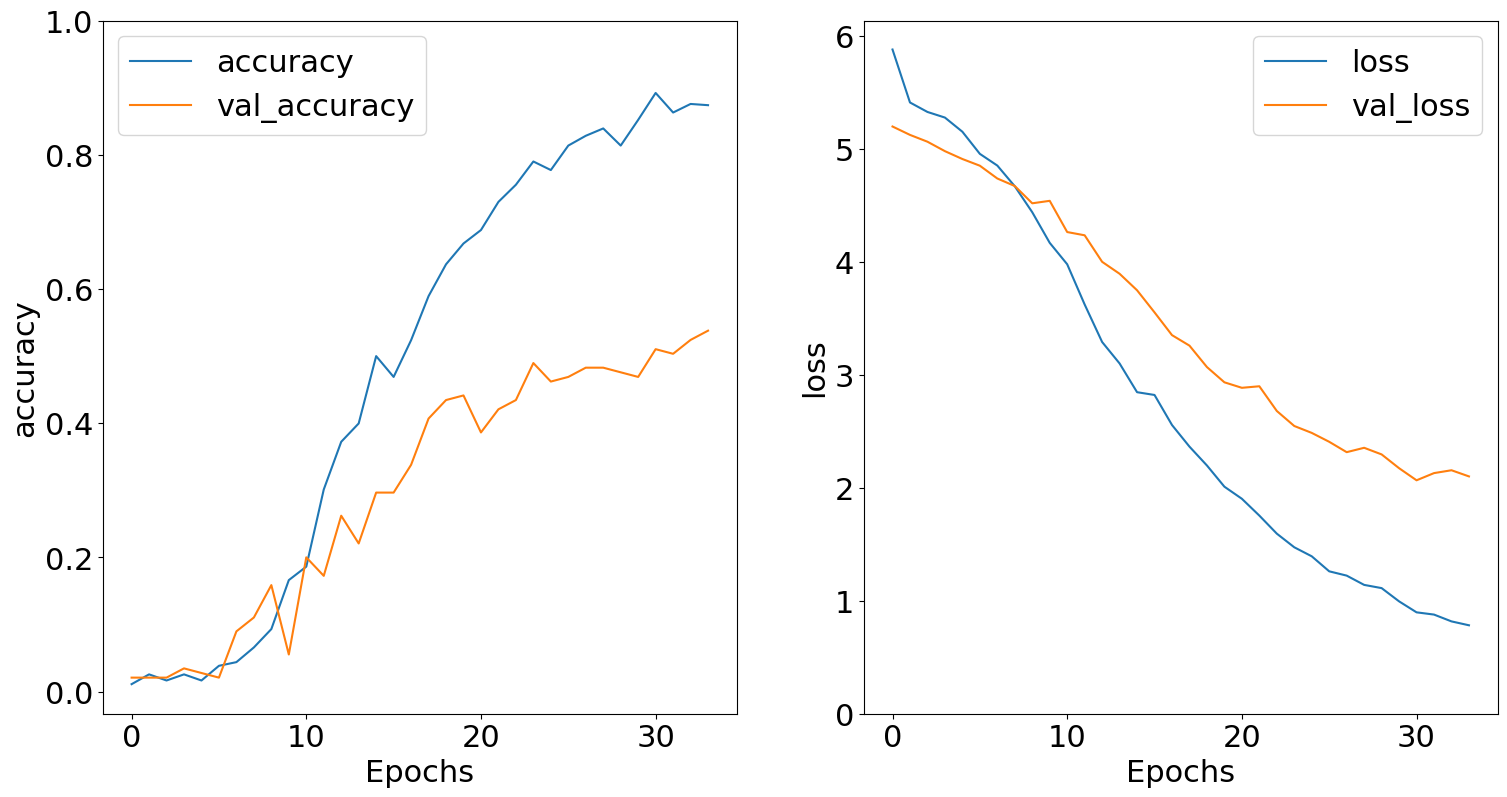

In [30]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(model,'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(model, 'loss')
plt.ylim(0, None)
plt.savefig('result', dpi=200, transparent=True, format='svg')

In [31]:

inp = 'काठमाडौं इन्जिनियरिङ कलेजको स्थापना कहिले भएको हो?'
result = model.predict(tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len), verbose=0)
print(NUM_CLASSES)
print(len(result[0]))
print(np.max(result))

if np.max(result) > 0.01:
  tag = le.inverse_transform([np.argmax(result)])
  print(tag)
else:
  print('not found')


69
69
0.9608268
['establish']


In [32]:
print(result[0])


[3.37921010e-05 1.14588274e-05 4.32198867e-04 5.66236158e-05
 7.24911224e-04 6.82354876e-05 2.39798246e-04 2.37075947e-04
 5.10112623e-05 1.61029617e-04 2.84834561e-04 5.86797134e-04
 4.54078458e-04 2.45343777e-04 1.72262720e-04 2.66416064e-05
 1.86397240e-03 3.58244497e-03 9.18615784e-04 3.31885368e-03
 5.24189556e-03 1.77834852e-04 5.83894609e-04 4.07298867e-05
 2.94047466e-04 2.23775369e-05 1.83769938e-04 2.58155167e-04
 3.07195209e-04 5.33066195e-05 3.21163185e-04 3.13435012e-05
 6.19713610e-05 2.58944310e-05 5.18690331e-06 1.18233247e-05
 3.10782052e-05 6.10549323e-05 1.29109585e-05 3.05726862e-04
 5.22273840e-05 2.07191304e-04 1.57426344e-04 3.38245212e-04
 9.60826814e-01 9.49631867e-05 4.70445433e-04 6.51349267e-03
 1.52224069e-03 2.00235547e-04 9.45654028e-06 8.41802321e-05
 3.44805332e-04 2.29991367e-03 1.86708407e-04 4.01535159e-04
 2.20455360e-04 4.63304241e-05 8.05168471e-04 7.05538914e-05
 1.85992301e-03 7.90795912e-06 5.50121258e-05 3.98326229e-05
 1.56368609e-04 7.910437

In [35]:
# to save the trained model
model.save("/content/drive/MyDrive/custom/nmodel1")

import pickle

# to save the fitted tokenizer
with open('/content/drive/MyDrive/custom/ntokenizer1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# to save the fitted label encoder
with open('/content/drive/MyDrive/chatbot/nlabel_encoder1.pickle', 'wb') as ecn_file:
    pickle.dump(le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
storage = pd.DataFrame(columns=['Date'])


In [37]:
storage.to_csv('/content/drive/MyDrive/custom/storage.csv', index=False)


In [39]:
pip install fuzzywuzzy


In [40]:
pip install python-Levenshtein


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.8 MB/s eta 0:00:00


In [41]:
import json
from fuzzywuzzy import fuzz
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

import spacy
import random
import pickle

with open(data_path) as file:
    data = json.load(file)

storage = pd.read_csv('/content/drive/MyDrive/custom/storage.csv')

import spacy

NER = spacy.load("en_core_web_sm")

def chat():
    # load trained model
    model = keras.models.load_model('/content/drive/MyDrive/custom/model1')

    # load tokenizer object
    with open('/content/drive/MyDrive/custom/tokenizer1.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('/content/drive/MyDrive/custom/label_encoder1.pickle', 'rb') as enc:
        le = pickle.load(enc)

       # load Spacy NER
    nlp = spacy.load("en_core_web_sm")

    # parameters
    max_len = 20

    while True:
        print("User: ")
        inp = input()
        text = nlp(inp)
        for word in text.ents:
            if word.label_ == 'DATE':
                storage['Date'] = word.text

        if inp.lower() == "quit":
            break

        # Fuzzy String Matching
        max_similarity = 0
        best_match_tag = None

        for i in data['intents']:
            for pattern in i['patterns']:
                similarity = fuzz.ratio(inp.lower(), pattern.lower())
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_match_tag = i['tag']

        if max_similarity >= 80:  # Adjust the similarity threshold as needed
            tag = best_match_tag
        else:
            result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                                 truncating='post', maxlen=max_len), verbose=0)
            tag = le.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                selected_response = np.random.choice(i['responses'])

                print("Selected Response:", selected_response)  # Debugging print statement

                if 'text' in selected_response:
                    print("ChatBot: " + selected_response['text'])

                if 'table' in selected_response:
                    headers = selected_response['table']['headers']
                    rows = selected_response['table']['rows']

                    # Display the table
                    print("ChatBot:")
                    print(f"{headers[0]:<30} {headers[1]}")
                    for row in rows:
                        if len(row) >= 2:
                            print(f"{row[0]:<30} {row[1]}")
                        else:
                            print("Invalid table row format.")




In [42]:
print("Start messaging with the bot (type quit to stop)!")
chat()

Start messaging with the bot (type quit to stop)!


OSError: No file or directory found at /content/drive/MyDrive/custom/model1